<center> <h1> Diagnose Latent Cytomegalovirus Using CyTOF Data and Deep Learning <h1> </center>

<center>Zicheng Hu, Ph.D.</center>
<center>Research Scientist</center>
<center>ImmPort Team</center>
<center>The Unversity of California, San Francisco</center>

![alt text](Data/header.png)

In [1]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus
import time

In [2]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
phenotype = 'Expsample Treatement'

In [4]:
##### Step 2: load data #####

tutorial_files = ! ls Data
if "allData.obj" not in tutorial_files:
    print("Downloading Data:")
    ! wget https://ucsf.box.com/shared/static/tn8m9hco3f3gugn7z394yzimvtfdg129.obj -O ./Data/allData.obj
        
#load data
with open("FCS_to_Array/agingData.obj", "rb") as f:
    allData = pickle.load(f)
metaData = allData["samples"]
cytoData = allData['expr_list']
markerNames = allData["marker_names"]

print("Dimensions of cytoData: ",cytoData.shape,"\n")
print("Names of the makers: \n",markerNames.values)

Dimensions of cytoData:  (753, 20000, 13, 1) 

Names of the makers: 
 ['FSC-A' 'FSC-H' 'FSC-W' 'SSC-A' 'SSC-H' 'SSC-W' 'PSTAT1' 'PSTAT5' 'CD66B'
 'CD33' 'CD3/CD14' 'PSTAT3' 'CD4/CD19']


In [5]:
##### Step 3: split train, validation and test######
phenos = sorted(set(metaData[phenotype].values))
y = np.array([phenos.index(_) for _ in metaData[phenotype].values])
y = y.reshape(list(y.shape)+[1])
x = cytoData
pheno_map = dict(enumerate(phenos))

x_train, x_valid, y_train, y_valid = train_test_split(x, y)
# train_id = (metaData.study_accession.isin(["SDY515","SDY519"])==False)
# valid_id = metaData.study_accession=="SDY515"
# test_id = metaData.study_accession =="SDY519"

# x_train = x[train_id]; y_train = y[train_id]
# x_valid = x[valid_id]; y_valid = y[valid_id]
# x_test = x[test_id]; y_test = y[test_id]

In [6]:
list(metaData[phenotype].values) == [pheno_map[_[0]] for _ in y]

True

In [7]:
##### Step 4: define model #####

# input
model_input = Input(shape=x_train[0].shape)

# first convolution layer
model_output = Conv2D(3, kernel_size=(1, x_train.shape[2]),
                 activation=None)(model_input)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# sceond convolution layer
model_output = Conv2D(3, (1, 1), activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# pooling layer
model_output = AveragePooling2D(pool_size=(x_train.shape[1], 1))(model_output)
model_output = Flatten()(model_output)

# Dense layer
model_output = Dense(3, activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("relu")(model_output)

# output layer
model_output = Dense(1, activation=None)(model_output)
model_output = BatchNormalization()(model_output)
model_output = Activation("sigmoid")(model_output)

##### Step 5: Fit model #####

# specify input and output
model = Model(inputs=[model_input],
              outputs=model_output)

# define loss function and optimizer
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20000, 13, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20000, 1, 3)       42        
_________________________________________________________________
batch_normalization (BatchNo (None, 20000, 1, 3)       12        
_________________________________________________________________
activation (Activation)      (None, 20000, 1, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20000, 1, 3)       12        
_________________________________________________________________
batch_normalization_1 (Batch (None, 20000, 1, 3)       12        
_________________________________________________________________
activation_1 (Activation)    (None, 20000, 1, 3)       0     

In [8]:
x.shape

(753, 20000, 13, 1)

In [9]:
aging_model = Sequential([
    Input(shape=x[0].shape),
    Conv2D(12, kernel_size = (1, x.shape[2]), activation=None),
#     BatchNormalization(),
    Activation('relu'),
    Conv2D(3, kernel_size = (1,1), activation=None),
#     BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size = (x.shape[1], 1)),
    Flatten(),
    Dense(12, activation=None),
#     BatchNormalization(),
    Activation('relu'),
    Dense(len(pheno_map), activation=None),
#     BatchNormalization(),
#     Activation('sigmoid'),
    Softmax(),
])
aging_model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
aging_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 20000, 1, 12)      168       
_________________________________________________________________
activation_4 (Activation)    (None, 20000, 1, 12)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20000, 1, 3)       39        
_________________________________________________________________
activation_5 (Activation)    (None, 20000, 1, 3)       0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 3)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                4

In [11]:
model = aging_model

# save the best performing model
checkpointer = ModelCheckpoint(filepath='Result/saved_weights.hdf5', 
                               monitor='val_loss', verbose=0, 
                               save_best_only=True)

st = time.time()
# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=20, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([x_valid], y_valid))
rt = time.time()-st

Epoch 1/20
10/10 [==============================] - 4s 177ms/step - loss: 1.6103 - accuracy: 0.1945 - val_loss: 1.6090 - val_accuracy: 0.1958
Epoch 2/20
10/10 [==============================] - 0s 43ms/step - loss: 1.6093 - accuracy: 0.2155 - val_loss: 1.6097 - val_accuracy: 0.1852
Epoch 3/20
10/10 [==============================] - 0s 43ms/step - loss: 1.6093 - accuracy: 0.2170 - val_loss: 1.6099 - val_accuracy: 0.1852
Epoch 4/20
10/10 [==============================] - 0s 43ms/step - loss: 1.6094 - accuracy: 0.1985 - val_loss: 1.6102 - val_accuracy: 0.1746
Epoch 5/20
10/10 [==============================] - 0s 43ms/step - loss: 1.6087 - accuracy: 0.2142 - val_loss: 1.6104 - val_accuracy: 0.1852
Epoch 6/20
10/10 [==============================] - 0s 43ms/step - loss: 1.6097 - accuracy: 0.1740 - val_loss: 1.6104 - val_accuracy: 0.1799
Epoch 7/20
10/10 [==============================] - 0s 42ms/step - loss: 1.6094 - accuracy: 0.1965 - val_loss: 1.6104 - val_accuracy: 0.1799
Epoch 8/20
1

In [12]:
rt

12.976404428482056

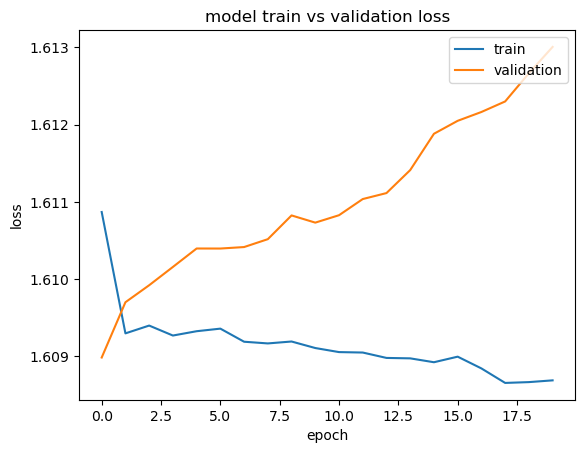

In [13]:
##### Step 6: plot train and validation loss #####
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

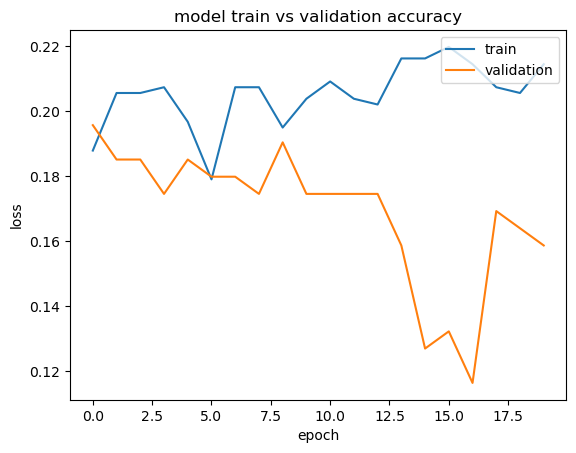

In [14]:
##### Step 6: plot train and validation accuracy #####
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [15]:
##### Step 7: test the final model #####

# # load final model
# # final_model = load_model('Data/Final_weights.hdf5')
# final_model = model
# x_test = x_valid
# y_test = y_valid

# # generate ROC and AUC
# y_scores = final_model.predict([x_test])

In [16]:
# fpr, tpr, _ = roc_curve(y_test, y_scores)
# roc_auc = auc(fpr, tpr)

# # plot ROC curve
# plt.plot(fpr, tpr)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('AUC = {0:.2f}'.format(roc_auc))
# plt.show()

ValueError: multiclass format is not supported